In [1]:
%matplotlib inline

In [2]:
from astropy.table import Table 
chain = Table.read('ssfr_dependent_chain.dat', format='ascii')
chain.sort('lnprob')
print(chain[-1])

prob1_disrupt prob2_disrupt frac_migration  lnprob
------------- ------------- -------------- -------
       0.2571        0.0859         0.4092 -0.0218


## Load SDSS one-point measurements

In [3]:
from empirical_disk_bulge.observations import load_umachine_sdss_complete

sdss = load_umachine_sdss_complete()
mask = sdss['type_mendel13'] != 4
mask *= sdss['deltaBD_mendel13'] <= 1
cut_sdss = sdss[mask]

from empirical_disk_bulge.observations import sfr_sequence_bulge_disk_fractions_vs_sm as bt_measurement
_result = bt_measurement(cut_sdss['bt'], cut_sdss['sm'], cut_sdss['ssfr'])

sm_abscissa_sdss, frac_disk_dom_all_sdss, frac_bulge_dom_all_sdss,\
    frac_disk_dom_sfs_sdss, frac_bulge_dom_sfs_sdss, \
    frac_disk_dom_gv_sdss, frac_bulge_dom_gv_sdss, \
    frac_disk_dom_q_sdss, frac_bulge_dom_q_sdss = _result


## Load `UniverseMachine` mock

In [4]:
from umachine_pyio.load_mock import value_added_mock, load_mock_from_binaries
subvolumes = np.random.choice(np.arange(144), 50, replace=False)
vamock = value_added_mock(load_mock_from_binaries(subvolumes), 250)
sfrh, smh = vamock['sfr_history_main_prog'].data, vamock['sm_history_main_prog'].data
sm = np.log10(vamock['obs_sm'].data)
ssfr = np.log10(vamock['obs_sfr'].data/vamock['obs_sm'].data)

from umachine_pyio.load_mock import get_snapshot_times
cosmic_age_array = get_snapshot_times()

Total runtime = 14.31 seconds


## Generate model predictions for ${\rm B/T} \equiv M_{\ast}^{\rm bulge}/(M_{\ast}^{\rm bulge}+M_{\ast}^{\rm disk})$

In [15]:
import empirical_disk_bulge.models.simple_disruption_models
reload(empirical_disk_bulge.models.simple_disruption_models)

def model_prediction(params, sm, ssfr, smh, sfrh, tarr, noise_level):
    frac_migration, prob1, prob2 = params

    zobs = 0.
    sm_disk, sm_bulge = empirical_disk_bulge.models.simple_disruption_models.ssfr_dependent_disruption(sfrh, smh, tarr, zobs, 
                                                   frac_migration, prob1, prob2, bt_noise=noise_level)    
    bt = sm_bulge/(sm_disk + sm_bulge)
    
    return bt_measurement(bt, sm, ssfr, return_data_vector=False), sm_disk, sm_bulge

In [23]:
frac_migration, prob1, prob2 = chain['frac_migration'][-1], chain['prob1_disrupt'][-1], chain['prob2_disrupt'][-1]
params1 = frac_migration, prob1, prob2

bt_result_model1, sm_disk_model1, sm_bulge_model1 = model_prediction(params1, sm, ssfr, 
                                                                     smh, sfrh, cosmic_age_array, 0.1)

sm_abscissa_model1, frac_disk_dom_all_model1, frac_bulge_dom_all_model1,\
    frac_disk_dom_sfs_model1, frac_bulge_dom_sfs_model1, \
    frac_disk_dom_gv_model1, frac_bulge_dom_gv_model1, \
    frac_disk_dom_q_model1, frac_bulge_dom_q_model1 = bt_result_model1

# print("frac_migration, P_disrupt(-11.25), P_disrupt(-9) = {0:.2f}, {1:.2f}, {2:.2f}".format(*params1))

bt_noise = 0.1


In [24]:
frac_migration, prob1, prob2 = params1
params2 = frac_migration, prob1, prob2

bt_result_model2, sm_disk_model2, sm_bulge_model2 = model_prediction(params2, sm, ssfr, 
                                                                     smh, sfrh, cosmic_age_array, 0.2)

sm_abscissa_model2, frac_disk_dom_all_model2, frac_bulge_dom_all_model2,\
    frac_disk_dom_sfs_model2, frac_bulge_dom_sfs_model2, \
    frac_disk_dom_gv_model2, frac_bulge_dom_gv_model2, \
    frac_disk_dom_q_model2, frac_bulge_dom_q_model2 = bt_result_model2

# print("frac_migration, P_disrupt(-11.25), P_disrupt(-9) = {0:.2f}, {1:.2f}, {2:.2f}".format(*params2))

bt_noise = 0.2


## Plot comparison of one-point summary statistic to data

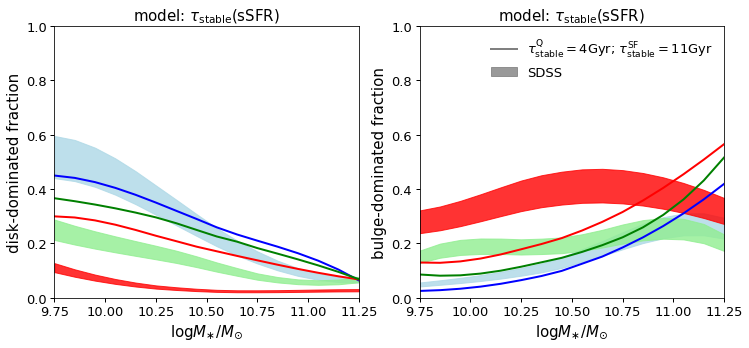

In [31]:
from scipy.signal import savgol_filter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

a, b = 11, 3

fracerr = 0.15
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightblue', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightgreen', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='red', alpha=0.8, label='SDSS')

ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightblue', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightgreen', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='red', alpha=0.8, label='SDSS')

xlabel1 = ax1.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
xlabel2 = ax2.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
ylabel1 = ax1.set_ylabel(r'disk-dominated fraction', size=15)
ylabel2 = ax2.set_ylabel(r'bulge-dominated fraction', size=15)

xmin, xmax = 9.75, 11.25
xlim1 = ax1.set_xlim(xmin, xmax)
xlim2 = ax2.set_xlim(xmin, xmax)
ymin, ymax = 0, 1
ylim1 = ax1.set_ylim(ymin, ymax)
ylim2 = ax2.set_ylim(ymin, ymax)

__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_sfs_model1, a, b), 
            color='blue', lw=2)
__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_q_model1, a, b), 
            color='red', lw=2)
__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_gv_model1, a, b), 
            color='green', lw=2, 
            label=r'$\tau_{\rm stable}^{\rm Q} = 4$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')

__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_sfs_model1, a, b), 
            color='blue', lw=2)
__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_q_model1, a, b), 
            color='red', lw=2)
__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_gv_model1, a, b), lw=2, 
            color='green', label=r'$\tau_{\rm stable}^{\rm Q} = 4$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')

# __=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_sfs_model2, a, b), 
#             '--', color='blue', lw=2)
# __=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_q_model2, a, b), 
#             '--', color='red', lw=2)
# __=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_gv_model2, a, b), 
#             '--', color='green', lw=2, 
#             label=r'$\tau_{\rm stable}^{\rm Q} = 4$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')

# __=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_sfs_model2, a, b), 
#             '--', color='blue', lw=2)
# __=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_q_model2, a, b), 
#             '--', color='red', lw=2)
# __=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_gv_model2, a, b), 
#             '--', lw=2, color='green', 
#             label=r'$\tau_{\rm stable}^{\rm Q} = 2$Gyr; $\tau_{\rm stable}^{\rm SF} = 11$Gyr')


legend2 = ax2.legend()
for leg in legend2.legendHandles: 
    leg.set_color('gray')

title1 = ax1.set_title(r'model: $\tau_{\rm stable}({\rm sSFR})$')
title2 = ax2.set_title(r'model: $\tau_{\rm stable}({\rm sSFR})$')

fig.savefig('ssfr_dependent_disruption.pdf', 
            bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')


## Compare plots of full PDFs

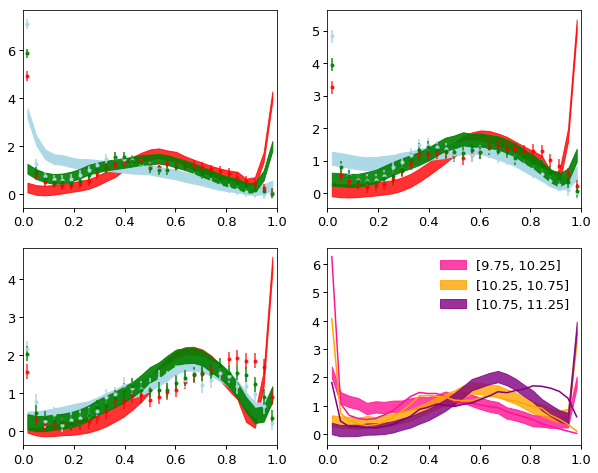

In [32]:
from scipy.signal import savgol_filter

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

bt_bins = np.linspace(0, 1, 30)
bt_mids = 0.5*(bt_bins[:-1] + bt_bins[1:])

logsm_low, logsm_high = 9.75, 10.25
sm_all_mask = (cut_sdss['sm'] >= logsm_low) & (cut_sdss['sm'] < logsm_high)
sm_q_mask = sm_all_mask & (cut_sdss['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (cut_sdss['ssfr'] >= -11.25) & (cut_sdss['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (cut_sdss['ssfr'] > -10.75)

bt_pdf_all = np.histogram(cut_sdss['bt'][sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = savgol_filter(np.histogram(cut_sdss['bt'][sm_q_mask], density=True, bins=bt_bins)[0], 7, 3)
bt_pdf_gv = savgol_filter(np.histogram(cut_sdss['bt'][sm_gv_mask], density=True, bins=bt_bins)[0], 7, 3)
bt_pdf_sf = savgol_filter(np.histogram(cut_sdss['bt'][sm_sf_mask], density=True, bins=bt_bins)[0], 7, 3)

__=ax1.fill_between(bt_mids, bt_pdf_q-0.2, bt_pdf_q+0.2, color='red', alpha=0.8)
__=ax1.fill_between(bt_mids, bt_pdf_sf-0.2, bt_pdf_sf+0.2, color='lightblue', alpha=1)
__=ax1.fill_between(bt_mids, bt_pdf_gv-0.2, bt_pdf_gv+0.2, color='green', alpha=0.9)

__=ax4.fill_between(bt_mids, bt_pdf_all-0.2, bt_pdf_all+0.2, 
                    alpha=0.8, label='[9.75, 10.25]', color='deeppink')

logsm_low, logsm_high = 10.25, 10.75
sm_all_mask = (cut_sdss['sm'] >= logsm_low) & (cut_sdss['sm'] < logsm_high)
sm_q_mask = sm_all_mask & (cut_sdss['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (cut_sdss['ssfr'] >= -11.25) & (cut_sdss['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (cut_sdss['ssfr'] > -10.75)

bt_pdf_all = np.histogram(cut_sdss['bt'][sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = savgol_filter(np.histogram(cut_sdss['bt'][sm_q_mask], density=True, bins=bt_bins)[0], 7, 3)
bt_pdf_gv = savgol_filter(np.histogram(cut_sdss['bt'][sm_gv_mask], density=True, bins=bt_bins)[0], 7, 3)
bt_pdf_sf = savgol_filter(np.histogram(cut_sdss['bt'][sm_sf_mask], density=True, bins=bt_bins)[0], 7, 3)

__=ax2.fill_between(bt_mids, bt_pdf_q-0.2, bt_pdf_q+0.2, color='red', alpha=0.8)
__=ax2.fill_between(bt_mids, bt_pdf_sf-0.2, bt_pdf_sf+0.2, color='lightblue', alpha=1)
__=ax2.fill_between(bt_mids, bt_pdf_gv-0.2, bt_pdf_gv+0.2, color='green', alpha=0.9)

__=ax4.fill_between(bt_mids, bt_pdf_all-0.2, bt_pdf_all+0.2, 
                    alpha=0.8, label='[10.25, 10.75]', color='orange')

logsm_low, logsm_high = 10.75, 11.25
sm_all_mask = (cut_sdss['sm'] >= logsm_low) & (cut_sdss['sm'] < logsm_high)
sm_q_mask = sm_all_mask & (cut_sdss['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (cut_sdss['ssfr'] >= -11.25) & (cut_sdss['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (cut_sdss['ssfr'] > -10.75)

bt_pdf_all = np.histogram(cut_sdss['bt'][sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = savgol_filter(np.histogram(cut_sdss['bt'][sm_q_mask], density=True, bins=bt_bins)[0], 7, 3)
bt_pdf_gv = savgol_filter(np.histogram(cut_sdss['bt'][sm_gv_mask], density=True, bins=bt_bins)[0], 7, 3)
bt_pdf_sf = savgol_filter(np.histogram(cut_sdss['bt'][sm_sf_mask], density=True, bins=bt_bins)[0], 7, 3)

__=ax3.fill_between(bt_mids, bt_pdf_q-0.2, bt_pdf_q+0.2, color='red', alpha=0.8)
__=ax3.fill_between(bt_mids, bt_pdf_sf-0.2, bt_pdf_sf+0.2, color='lightblue', alpha=1)
__=ax3.fill_between(bt_mids, bt_pdf_gv-0.2, bt_pdf_gv+0.2, color='green', alpha=0.9)

__=ax4.fill_between(bt_mids, bt_pdf_all-0.2, bt_pdf_all+0.2, 
                    alpha=0.8, label='[10.75, 11.25]', color='purple')

#  Overplot model(s)
vamock['ssfr'] = np.log10(vamock['obs_sfr']/vamock['obs_sm'])

obs_sm_disk_model1 = 10**(np.random.normal(loc=np.log10(sm_disk_model1), scale=0.1))
obs_sm_bulge_model1 = 10**(np.random.normal(loc=np.log10(sm_bulge_model1), scale=0.1))
obs_bt_model1 = obs_sm_bulge_model1/(obs_sm_disk_model1 + obs_sm_bulge_model1)

bt_model1 = sm_bulge_model1/(sm_disk_model1 + sm_bulge_model1)
bt_model2 = sm_bulge_model2/(sm_disk_model2 + sm_bulge_model2)




logsm_low, logsm_high = 9.75, 10.25
sm_all_mask = (vamock['obs_sm'] >= 10**logsm_low) & (vamock['obs_sm'] < 10**logsm_high)
sm_q_mask = sm_all_mask & (vamock['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (vamock['ssfr'] >= -11.25) & (vamock['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (vamock['ssfr'] > -10.75)

bt_pdf_all = np.histogram(bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = np.histogram(bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
bt_pdf_gv = np.histogram(bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
bt_pdf_sf = np.histogram(bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax1.errorbar(bt_mids, bt_pdf_q, 0.2, fmt='.', color='red', alpha=0.8)
__=ax1.errorbar(bt_mids, bt_pdf_sf, 0.2, fmt='.', color='lightblue', alpha=1)
__=ax1.errorbar(bt_mids, bt_pdf_gv, 0.2, fmt='.', color='green', alpha=0.9)

__=ax4.plot(bt_mids, bt_pdf_all, color='deeppink')

logsm_low, logsm_high = 10.25, 10.75
sm_all_mask = (vamock['obs_sm'] >= 10**logsm_low) & (vamock['obs_sm'] < 10**logsm_high)
sm_q_mask = sm_all_mask & (vamock['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (vamock['ssfr'] >= -11.25) & (vamock['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (vamock['ssfr'] > -10.75)

bt_pdf_all = np.histogram(bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = np.histogram(bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
bt_pdf_gv = np.histogram(bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
bt_pdf_sf = np.histogram(bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax2.errorbar(bt_mids, bt_pdf_q, 0.2, fmt='.', color='red', alpha=0.8)
__=ax2.errorbar(bt_mids, bt_pdf_sf, 0.2, fmt='.', color='lightblue', alpha=1)
__=ax2.errorbar(bt_mids, bt_pdf_gv, 0.2, fmt='.', color='green', alpha=0.9)

__=ax4.plot(bt_mids, bt_pdf_all, color='orange')

logsm_low, logsm_high = 10.75, 11.25
sm_all_mask = (vamock['obs_sm'] >= 10**logsm_low) & (vamock['obs_sm'] < 10**logsm_high)
sm_q_mask = sm_all_mask & (vamock['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (vamock['ssfr'] >= -11.25) & (vamock['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (vamock['ssfr'] > -10.75)

bt_pdf_all = np.histogram(bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = np.histogram(bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
bt_pdf_gv = np.histogram(bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
bt_pdf_sf = np.histogram(bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax3.errorbar(bt_mids, bt_pdf_q, 0.2, fmt='.', color='red', alpha=0.8)
__=ax3.errorbar(bt_mids, bt_pdf_sf, 0.2, fmt='.', color='lightblue', alpha=1)
__=ax3.errorbar(bt_mids, bt_pdf_gv, 0.2, fmt='.', color='green', alpha=0.9)

__=ax4.plot(bt_mids, bt_pdf_all, color='purple')



xlim1 = ax1.set_xlim(0, 1)
xlim2 = ax2.set_xlim(0, 1)
xlim3 = ax3.set_xlim(0, 1)
xlim4 = ax4.set_xlim(0, 1)

legend4 = ax4.legend()

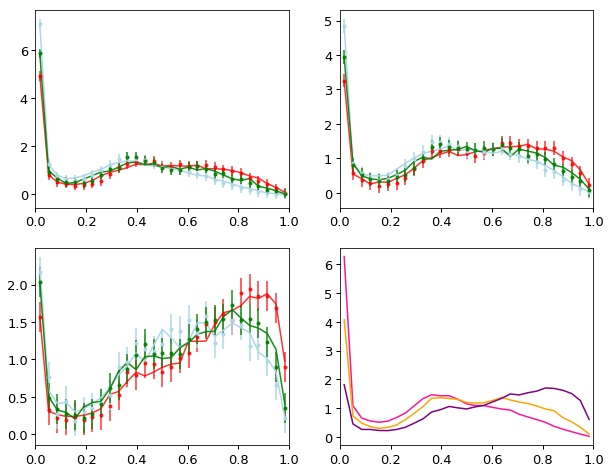

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))


logsm_low, logsm_high = 9.75, 10.25
sm_all_mask = (vamock['obs_sm'] >= 10**logsm_low) & (vamock['obs_sm'] < 10**logsm_high)
sm_q_mask = sm_all_mask & (vamock['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (vamock['ssfr'] >= -11.25) & (vamock['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (vamock['ssfr'] > -10.75)

bt_pdf_all = np.histogram(bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = np.histogram(bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
bt_pdf_gv = np.histogram(bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
bt_pdf_sf = np.histogram(bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax1.errorbar(bt_mids, bt_pdf_q, 0.2, fmt='.', color='red', alpha=0.8)
__=ax1.errorbar(bt_mids, bt_pdf_sf, 0.2, fmt='.', color='lightblue', alpha=1)
__=ax1.errorbar(bt_mids, bt_pdf_gv, 0.2, fmt='.', color='green', alpha=0.9)

__=ax4.plot(bt_mids, bt_pdf_all, color='deeppink')

obs_bt_pdf_all = np.histogram(obs_bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_q = np.histogram(obs_bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_gv = np.histogram(obs_bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_sf = np.histogram(obs_bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax1.plot(bt_mids, obs_bt_pdf_q,  color='red', alpha=0.8)
__=ax1.plot(bt_mids, obs_bt_pdf_sf,  color='lightblue', alpha=1)
__=ax1.plot(bt_mids, obs_bt_pdf_gv,  color='green', alpha=0.9)



logsm_low, logsm_high = 10.25, 10.75
sm_all_mask = (vamock['obs_sm'] >= 10**logsm_low) & (vamock['obs_sm'] < 10**logsm_high)
sm_q_mask = sm_all_mask & (vamock['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (vamock['ssfr'] >= -11.25) & (vamock['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (vamock['ssfr'] > -10.75)

bt_pdf_all = np.histogram(bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = np.histogram(bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
bt_pdf_gv = np.histogram(bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
bt_pdf_sf = np.histogram(bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax2.errorbar(bt_mids, bt_pdf_q, 0.2, fmt='.', color='red', alpha=0.8)
__=ax2.errorbar(bt_mids, bt_pdf_sf, 0.2, fmt='.', color='lightblue', alpha=1)
__=ax2.errorbar(bt_mids, bt_pdf_gv, 0.2, fmt='.', color='green', alpha=0.9)

__=ax4.plot(bt_mids, bt_pdf_all, color='orange')

obs_bt_pdf_all = np.histogram(obs_bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_q = np.histogram(obs_bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_gv = np.histogram(obs_bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_sf = np.histogram(obs_bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax2.plot(bt_mids, obs_bt_pdf_q,  color='red', alpha=0.8)
__=ax2.plot(bt_mids, obs_bt_pdf_sf,  color='lightblue', alpha=1)
__=ax2.plot(bt_mids, obs_bt_pdf_gv,  color='green', alpha=0.9)

logsm_low, logsm_high = 10.75, 11.25
sm_all_mask = (vamock['obs_sm'] >= 10**logsm_low) & (vamock['obs_sm'] < 10**logsm_high)
sm_q_mask = sm_all_mask & (vamock['ssfr'] < -11.25)
sm_gv_mask = sm_all_mask & (vamock['ssfr'] >= -11.25) & (vamock['ssfr'] < -10.75)
sm_sf_mask = sm_all_mask & (vamock['ssfr'] > -10.75)

bt_pdf_all = np.histogram(bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
bt_pdf_q = np.histogram(bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
bt_pdf_gv = np.histogram(bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
bt_pdf_sf = np.histogram(bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax3.errorbar(bt_mids, bt_pdf_q, 0.2, fmt='.', color='red', alpha=0.8)
__=ax3.errorbar(bt_mids, bt_pdf_sf, 0.2, fmt='.', color='lightblue', alpha=1)
__=ax3.errorbar(bt_mids, bt_pdf_gv, 0.2, fmt='.', color='green', alpha=0.9)

__=ax4.plot(bt_mids, bt_pdf_all, color='purple')

obs_bt_pdf_all = np.histogram(obs_bt_model1[sm_all_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_q = np.histogram(obs_bt_model1[sm_q_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_gv = np.histogram(obs_bt_model1[sm_gv_mask], density=True, bins=bt_bins)[0]
obs_bt_pdf_sf = np.histogram(obs_bt_model1[sm_sf_mask], density=True, bins=bt_bins)[0]

__=ax3.plot(bt_mids, obs_bt_pdf_q,  color='red', alpha=0.8)
__=ax3.plot(bt_mids, obs_bt_pdf_sf,  color='lightblue', alpha=1)
__=ax3.plot(bt_mids, obs_bt_pdf_gv,  color='green', alpha=0.9)


xlim1 = ax1.set_xlim(0, 1)
xlim2 = ax2.set_xlim(0, 1)
xlim3 = ax3.set_xlim(0, 1)
xlim4 = ax4.set_xlim(0, 1)

# legend4 = ax4.legend()

In [ ]:
vamock['ssfr'].min(), vamock['ssfr'].max()